In [20]:
import numpy as np
import matplotlib.pyplot as plt

def create_dataset(N, K=2):
    N = 100  # number of points per class
    D = 2
    X = np.zeros((N * K, D))  # data matrix (each row = single example)
    y = np.zeros(N * K)  # class labels

    for j in range(K):
        ix = range(N * j, N * (j + 1))
        r = np.linspace(0, 1, N)  # radius
        t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j
    # lets visualize the data:
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()

    return X, y


def plot_contour(X, y, model, parameters):
    # plot the resulting classifier
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    points = np.c_[xx.ravel(), yy.ravel()]

    # forward prop with our trained parameters
    _, Z = model.forward(points, parameters)

    # classify into highest prob
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)

    # plt the points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    # fig.savefig('spiral_net.png')

In [21]:
class NeuralNet():
    def __init__(self, X, y):
        self.m, self.n = X.shape
        self.lambd = 1e-3
        self.lr = 0.1

        self.h1 = 25
        self.h2 = len(np.unique(y))
    
    def init_kaiming_weights(self, l0, l1):
        # kaiming initilization
        w = np.random.randn(l0, l1) * np.sqrt(2.0/l0)
        b = np.zeros((1, l1))

        return w, b

    def forward(self, X, parameters):
        W2 = parameters['W2']
        W1 = parameters['W1']
        b2 = parameters['b2']
        b1 = parameters['b1']

        # forward prop
        a0 = X
        z1 = np.dot(a0, W1) + b1
        a1 = np.maximum(0, z1)
        z2 = np.dot(a1, W2) + b2

        # softmax

        scores = z2
        exp_scores = np.exp(scores)

        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        cache = {
            'a0' : a0,
            'probs': probs,
            'a1': a1
        }
        return cache, probs
        

    def compute_cost(self, y, probs, parameters):
        W2 = parameters['W2']
        W1 = parameters['W1']
        b2 = parameters['b2']
        b1 = parameters['b1']

        data_loss = np.sum(-np.log(probs[np.arange(self.m), y])/self.m)
        reg_loss = 0.5 * self.lambd * np.sum(W1*W1) + 0.5 * self.lambd* np.sum(W2*W2)

        total_cost = data_loss + reg_loss
        return total_cost

    def backward(self, cache, parameters, y):
        W2 = parameters['W2']
        W1 = parameters['W1']
        b2 = parameters['b2']
        b1 = parameters['b1']

        a0 = cache['a0']
        a1 = cache['a1']
        probs = cache['probs']

        dz2 = probs
        dz2[np.arange(self.m), y] -= 1
        dz2 /= self.m

        # backprop through values dW2 and db2
        dW2 = np.dot(a1.T, dz2) + self.lambd * W2
        db2 = np.sum(dz2, axis=0, keepdims=True)

        # Back to the (only) hidden layer in this case
        dz1 = np.dot(dz2, W2.T)
        dz1 = dz1 * (a1 > 0)

        # backprop through values dW1, db1
        dW1 = np.dot(a0.T, dz1) + self.lambd * W1
        db1 = np.sum(dz1, axis=0, keepdims=True)

        grads = {"dW1": dW1, "dW2": dW2, "db1": db1, "db2": db2}

        return grads
    
    def update_parameters(self, parameters, grads):
        # gradient descent
        learning_rate = self.lr

        W2 = parameters["W2"]
        W1 = parameters["W1"]
        b2 = parameters["b2"]
        b1 = parameters["b1"]

        dW2 = grads["dW2"]
        dW1 = grads["dW1"]
        db2 = grads["db2"]
        db1 = grads["db1"]

        # Do gradient descent step
        W2 -= learning_rate * dW2
        W1 -= learning_rate * dW1
        b2 -= learning_rate * db2
        b1 -= learning_rate * db1

        # store back weights in parameters
        parameters = {"W1": W1, "W2": W2, "b1": b1, "b2": b2}

        return parameters

    def train(self, X, y, num_iters=10000):
        # initialize our weights
        W1, b1 = self.init_kaiming_weights(self.n, self.h1)
        W2, b2 = self.init_kaiming_weights(self.h1, self.h2)

        # pack parameters into a dictionary
        parameters = {"W1": W1, "W2": W2, "b1": b1, "b2": b2}

        # How many gradient descent updates we want to do
        for it in range(num_iters + 1):

            # forward prop
            cache, probs = self.forward(X, parameters)

            # calculate cost
            cost = self.compute_cost(y, probs, parameters)

            # print cost sometimes
            if it % 2500 == 0:
                print(f"At iteration {it} we have a cost of {cost}")

            # back prop
            grads = self.backward(cache, parameters, y)

            # update parameters
            parameters = self.update_parameters(parameters, grads)

        return parameters



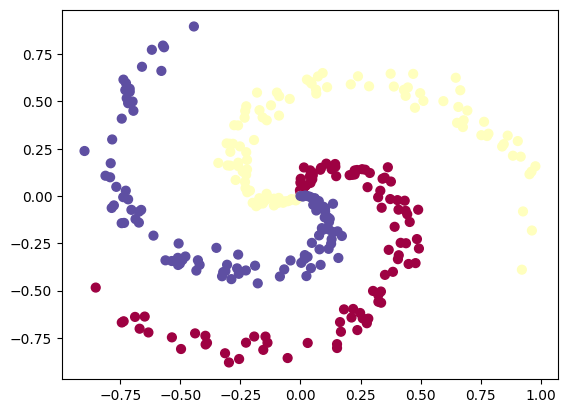

At iteration 0 we have a cost of 1.1638324693519033
At iteration 2500 we have a cost of 0.29689979602788
At iteration 5000 we have a cost of 0.26331521815431813
At iteration 7500 we have a cost of 0.2540019749968243
At iteration 10000 we have a cost of 0.2505719887384769


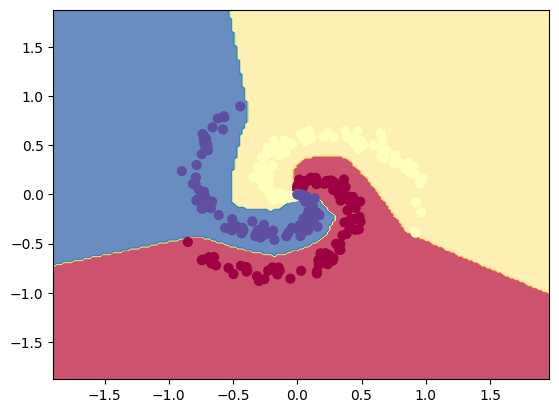

In [22]:
X, y = create_dataset(N=300, K=3)
y = y.astype(int)

# Train network
NN = NeuralNet(X, y)
trained_parameters = NN.train(X, y)

# Get trained parameters
W2 = trained_parameters["W2"]
W1 = trained_parameters["W1"]
b2 = trained_parameters["b2"]
b1 = trained_parameters["b1"]

# Plot the decision boundary (for nice visualization)
plot_contour(X, y, NN, trained_parameters)